In [57]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

sys.path.append(str(Path.cwd()))
from plotting_constants import colors

root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data"

idx = pd.IndexSlice

In [27]:

year = 2035

def get_load(year, mode, carrier):
    load = pd.read_csv(root / "nodal_loads.csv", index_col=[0,1], header=list(range(9)))

    load = load.loc[idx[:,carrier], idx[:, :, :, :, str(year), mode, "static", :, :]].copy()
    load.index = load.index.get_level_values(0)
    # load.name = f"({year}, {mode}, {carrier})"

    assert load.shape[1] == 1
    load.columns = [carrier]

    return load



,urban central heat
AL1 0,1.218825e+05
AT1 0,4.841844e+06
BA1 0,3.041203e+05
BE1 0,5.688733e+06
BG1 0,1.943106e+06
...,...
RS1 0,2.627581e+06
SE2 0,1.171491e+07
SE2 1,2.565629e+04
SI1 0,7.251568e+05


In [83]:
def get_gen(year, mode, carrier):

    cap = pd.read_csv(root / "nodal_capacities.csv", index_col=[0,1,2], header=list(range(9)))

    if isinstance(carrier, str):
        carrier = [carrier]
    
    cap = cap.loc[idx[:,:,carrier], idx[:,:,:,:,str(year),mode,"static",:,:]].copy()
    cap.index = cap.index.droplevel(0)
    cap = cap.unstack()
    cap.columns = carrier

    return cap.fillna(0)



In [55]:
geo = pd.read_csv(root / "nodal_geothermal_stats.csv", index_col=[0,1], header=list(range(9)))
geo.index.get_level_values(1).unique()

Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_total_generation', 'dac', 'geothermal heat chp elec',
       'geothermal heat dh', 'geothermal heat elec', 'offwind-ac', 'onwind',
       'solar', 'uch_geothermal_generation', 'uch_geothermal_generation_share',
       'uch_total_generation', 'offwind-dc'],
      dtype='object')

In [74]:
geo.index.get_level_values(1).unique()

Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_total_generation', 'dac', 'geothermal heat chp elec',
       'geothermal heat dh', 'geothermal heat elec', 'offwind-ac', 'onwind',
       'solar', 'uch_geothermal_generation', 'uch_geothermal_generation_share',
       'uch_total_generation', 'offwind-dc'],
      dtype='object')

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001EC7CF96290> (for post_execute):


KeyboardInterrupt: 

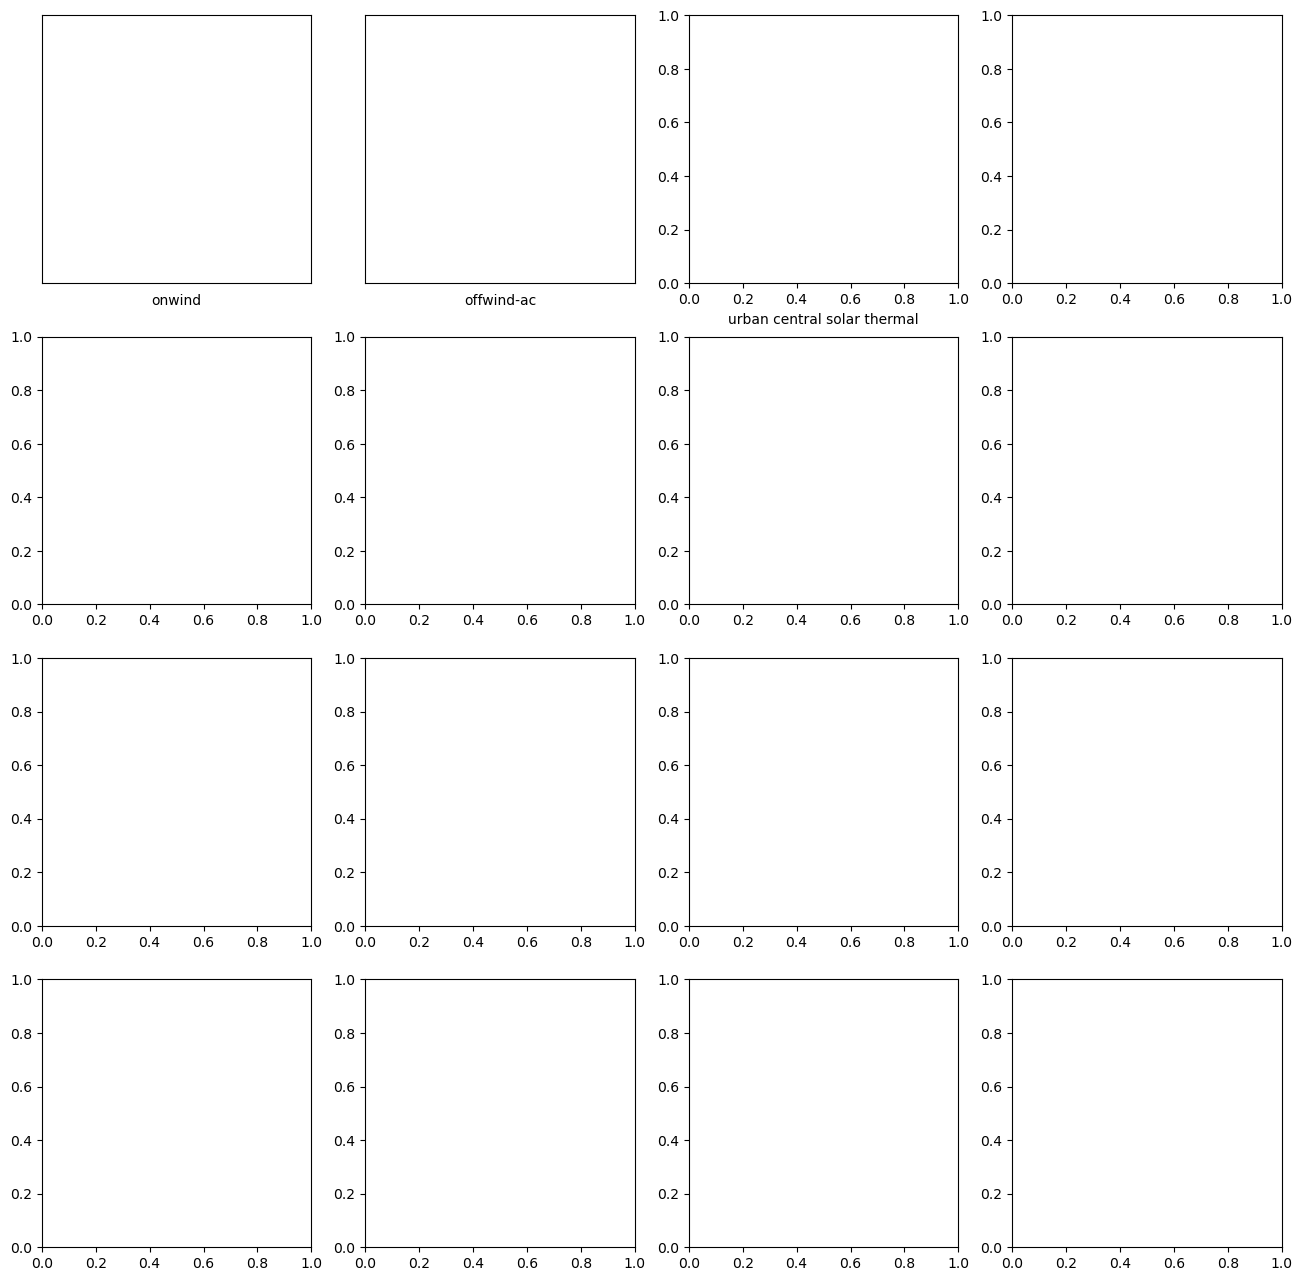

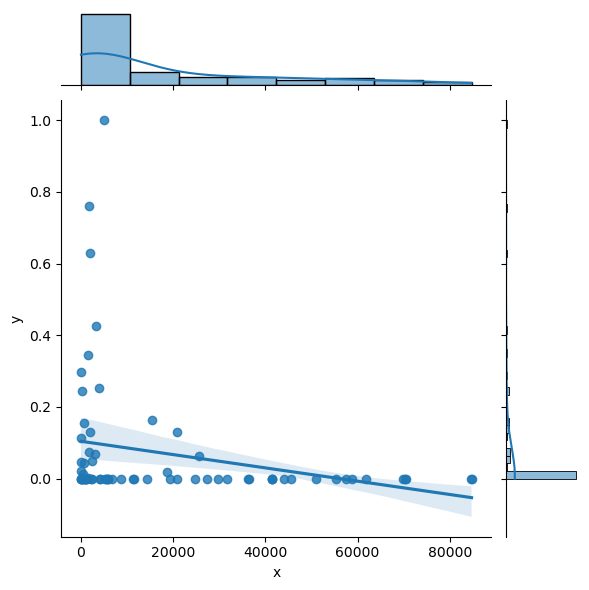

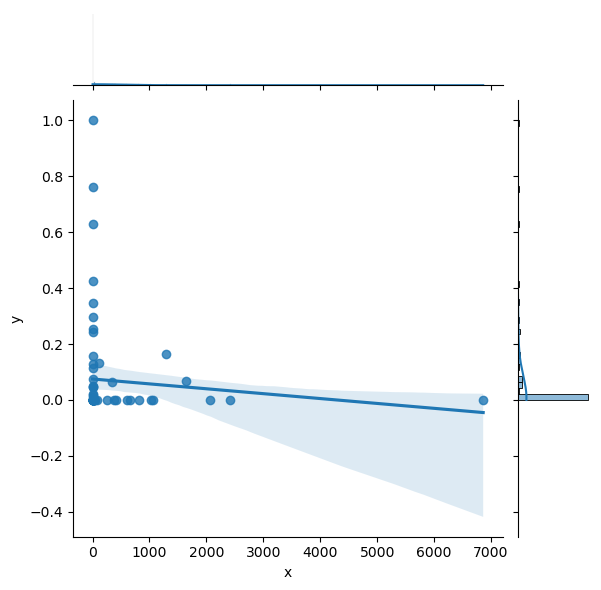

In [114]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler
# scaler = StandardScaler


geo.index.get_level_values(0).unique()

carriers = [
    "onwind",
    "offwind-ac",
    "injection geothermal heat",
    "urban central solar thermal",
    "solar",
    "solar rooftop",
    "DAC",
    "urban central water tanks charger",
    "urban central water tanks",
    "H2 Store",
    "electricity distribution grid",
]

def match_index(df, name):
    df.index = df.index.get_level_values(0)
    df.columns = [name]
    return df


years = {
    "dh": "2035",
    "chp": "2035",
    "elec": "2045",
}

import seaborn as sns

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i, mode in enumerate(["elec", "dh", "chp"]):

    data = pd.DataFrame(index=geo.index.get_level_values(0).unique())

    data[carriers] = get_gen(years[mode], mode, carriers)

    data["electricity demand"] = get_load(years[mode], mode, "electricity")
    data["urban central heat demand"] = get_load(years[mode], mode, "urban central heat")

    name = "dac_stats"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "dac"], idx[:, :, :, :, years[mode], mode, "static", :, :]].copy(), name)

    name = "onwind cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "onwind"], idx[:, :, :, :, years[mode], mode, "static", :, :]].copy(), name)

    name = "offwind-ac cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "offwind-ac"], idx[:, :, :, :, years[mode], mode, "static", :, :]].copy(), name)

    name = "solar cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "solar"], idx[:, :, :, :, years[mode], mode, "static", :, :]].copy(), name)

    data = data.fillna(0)

    # scatter_kwarg = {
    #     "s": 20,
    #     "alpha": 0.5,
    #     "edgecolor": "k"
    # }
    # data = pd.DataFrame(scaler().fit_transform(data), columns=data.columns, index=data.index)

    if mode != "elec":
        data = data.sort_values(by="injection geothermal heat", ascending=True).iloc[:-1]    

    y = MinMaxScaler().fit_transform(data[["injection geothermal heat"]])
    X = data.drop(columns=["injection geothermal heat"])

    for col, ax in zip(X.columns, axs.flatten()):
        # ax.scatter(data[col], y.flatten(), color=colors[mode], s=20, alpha=0.8, edgecolor="k", label=col)
        # ax.legend()
        ax.set_xlabel(col)
        # ax.set_ylim(-0.05, 1.05, 2.5)

        d = pd.DataFrame({'y': y.flatten(), 'x': data[col].values})
        # sns.jointplot(d, x='x', y='y', kind='reg', ax=ax)

        ax.set_xticks([])
        ax.set_yticks([])
        

for ax in axs[:,0]: ax.set_ylabel("injection geothermal heat")
for ax in axs.flatten(): ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

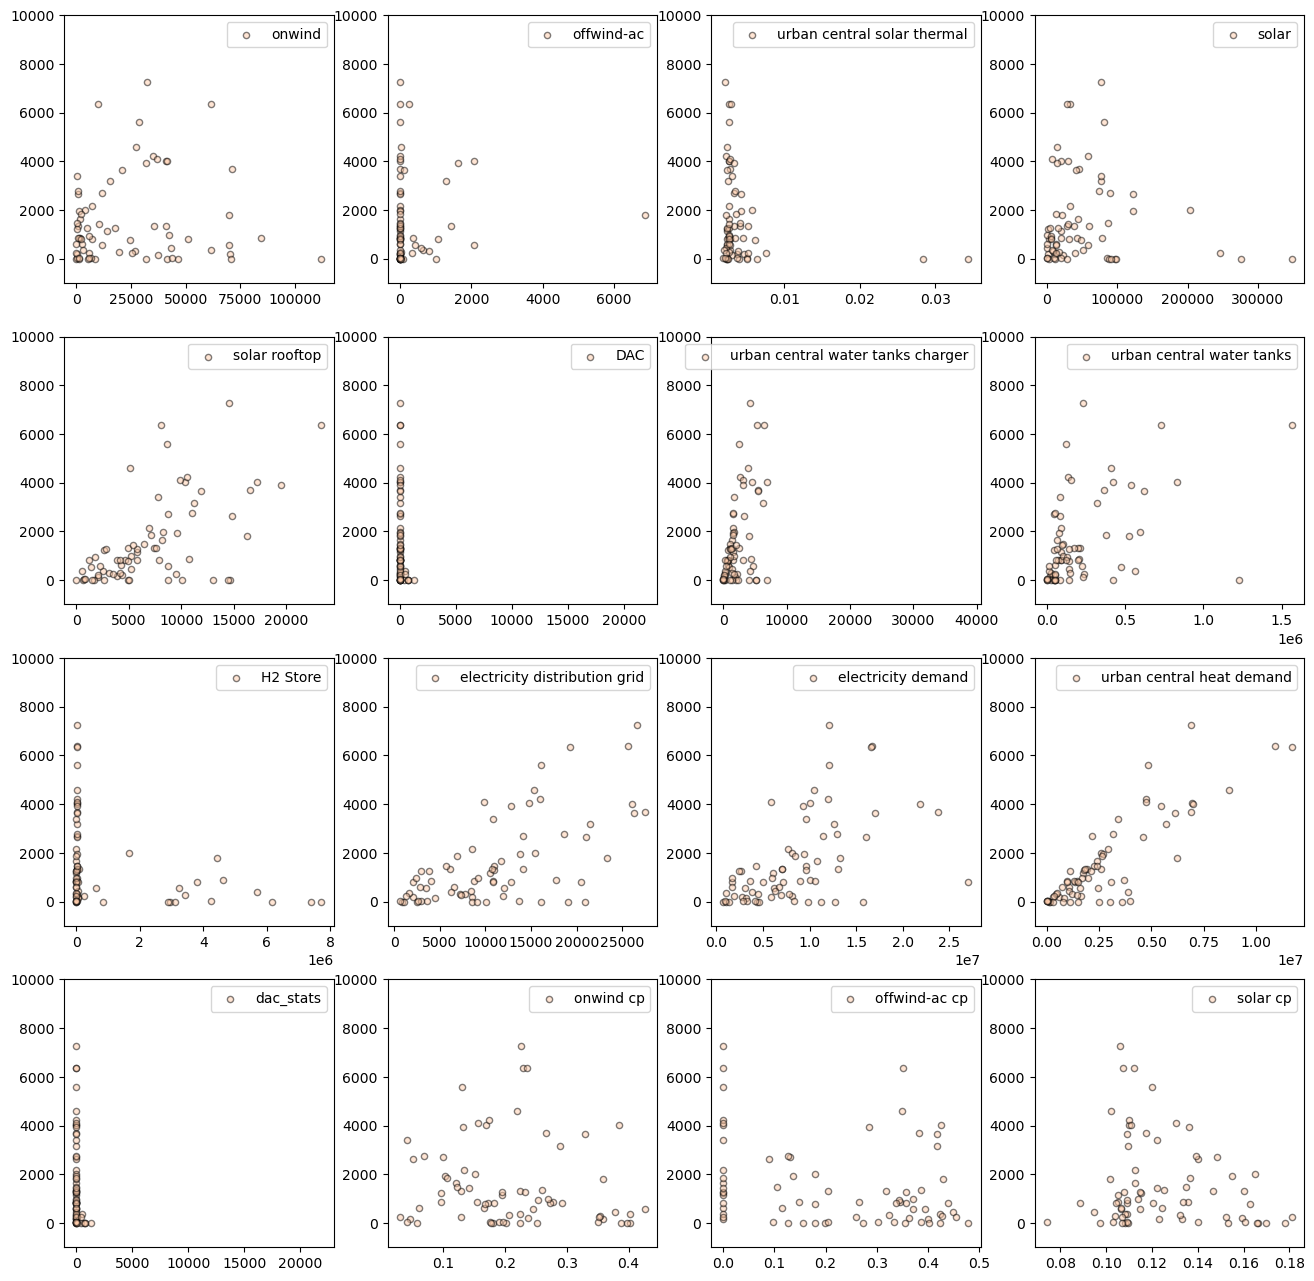

In [89]:


plt.show()

In [82]:
geo = pd.read_csv(root / "nodal_geothermal_stats.csv", index_col=[0,1], header=list(range(9)))
# print(geo.head())
print(geo.index.get_level_values(0).unique())
print(geo.index.get_level_values(1).unique())

# print(geo.loc[idx["FR1 7", "uch_geothermal_generation",:], :].iloc[:,:3])
# print(geo.loc[idx["FR1 7", "uch_geothermal_generation_share",:], :].iloc[:,:3])

gen = geo.loc[idx[:, "uch_geothermal_generation",:], :].values
share = geo.loc[idx[:, "uch_geothermal_generation_share",:], :].values

index = geo.loc[idx[:, "uch_geothermal_generation",:], :].index.get_level_values(0)

# (s / a)**(-1) - a
heat_demand = (share / gen)**(-1) - gen
heat_demand = pd.DataFrame(heat_demand, index=index, columns=geo.columns)

# print(heat_demand.mean())
print(heat_demand.loc[:,idx[:,:,:,:,:,"dh","static"]].mean(axis=1))
print(heat_demand.loc[:,idx[:,:,:,:,:,"dh","static"]].std(axis=1))


Index(['AL1 0', 'AT1 0', 'BA1 0', 'BE1 0', 'BG1 0', 'CH1 0', 'CZ1 0', 'DE1 0',
       'DE1 1', 'DE1 2', 'DE1 3', 'DE1 4', 'DE1 5', 'DE1 6', 'DE1 7', 'DE1 8',
       'DE1 9', 'DK1 0', 'DK2 0', 'EE6 0', 'ES1 0', 'ES1 1', 'ES1 2', 'ES1 3',
       'ES4 0', 'FI2 0', 'FR1 0', 'FR1 1', 'FR1 2', 'FR1 3', 'FR1 4', 'FR1 5',
       'FR1 6', 'FR1 7', 'FR1 8', 'FR1 9', 'GB0 0', 'GB0 1', 'GB0 2', 'GB0 3',
       'GB0 4', 'GB0 5', 'GB5 0', 'GR1 0', 'HR1 0', 'HU1 0', 'IE5 0', 'IT1 0',
       'IT1 1', 'IT1 2', 'IT1 3', 'IT1 4', 'IT1 5', 'IT3 0', 'LT6 0', 'LU1 0',
       'LV6 0', 'ME1 0', 'MK1 0', 'NL1 0', 'NL1 1', 'NO2 0', 'NO2 1', 'PL1 0',
       'PL1 1', 'PT1 0', 'RO1 0', 'RS1 0', 'SE2 0', 'SE2 1', 'SI1 0', 'SK1 0'],
      dtype='object', name='location')
Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_total_generation', 'dac', 'geothermal heat chp elec',
       'geothermal heat dh', 'geothermal heat elec', 'offwind-ac', 'onwind',
       'solar', 'uch_geothermal_genera

C:\Users\lukas\AppData\Local\Temp\ipykernel_15832\3930332230.py:15: RuntimeWarning: invalid value encountered in divide
  heat_demand = (share / gen)**(-1) - gen


In [47]:
share.shape

(72, 78)

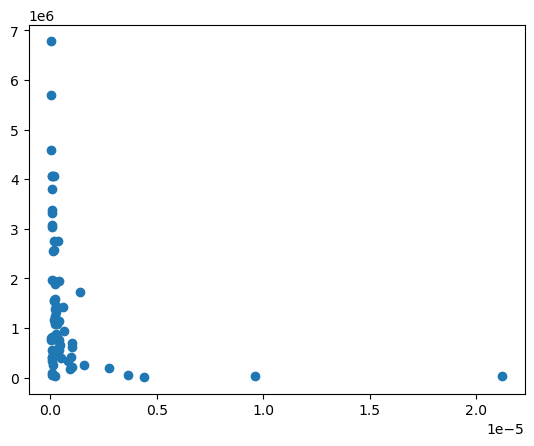

In [53]:
n = 30
gfgf = heat_demand.loc[:,idx[:,:,:,:,:,"dh","static"]].std(axis=1)
# plt.scatter(share[:,20], heat_demand.values[:,20])
plt.scatter(share[:,20], gfgf)

In [14]:
pd.read_csv(root / "nodal_costs.csv", index_col=[0,1,2,3], header=list(range(9)))

cluster                                                                                        72  \
ll                                                                                           v1.0   
opt                                                               Co2L0-3H-T-H-B-I-solar+p3-dist1   
planning_horizon                                                                             2050   
egs_capex                                                                                    1990   
egs_mode                                                                                      chp   
egs_op                                                                                     static   
progress                                                                                      0.3   
use_waste_heat                                                                               True   
generators capital  NaN   gas                                                            0.000000   
                          oil                                                            0.000000   
                    AL1 0 offwind-ac                                                   239.160990   
                          onwind                                                       262.514562   
                          residential rural solar thermal                              158.821070   
...                                                                                           ...   
stores     marginal SK1 0 residential rural water tanks                               -924.120222   
                          residential urban decentral water tanks                     -703.292645   
                          services rural water tanks                                  -530.008576   
                          services urban decentral water tanks                        -364.363509   
                          urban central water tanks                                  -1698.568311   

cluster                                                                         \
ll                                                                               
opt                                                                              
planning_horizon                                                                 
egs_capex                                                                        
egs_mode                                                                         
egs_op                                                                    flex   
progress                                                                   0.3   
use_waste_heat                                                            True   
generators capital  NaN   gas                                         0.000000   
                          oil                                         0.000000   
                    AL1 0 offwind-ac                                131.919445   
                          onwind                                    160.622954   
                          residential rural solar thermal            99.207798   
...                                                                        ...   
stores     marginal SK1 0 residential rural water tanks           -1080.575558   
                          residential urban decentral water tanks  -693.169564   
                          services rural water tanks               -501.518006   
                          services urban decentral water tanks     -345.300309   
                          urban central water tanks               -1654.905863   

cluster                                                                         \
ll                                                                               
opt                                                                              
planning_horizon                                                                 
egs_capex 

In [25]:
a = 3
b = 5
s = a/(a+b)

print(s)

0.375


In [57]:
import os
import pypsa
import numpy as np
import pandas as pd 

from pathlib import Path

root = Path.cwd().parent.parent.parent / "cluster_data" / "dump"

os.listdir(root)

n = pypsa.Network(root / "elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2020_elec_static_0.3_True.nc")

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2020_elec_static_0.3_True.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [77]:
n.loads.carrier.unique()

array(['electricity', 'land transport EV', 'land transport fuel cell',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'shipping methanol',
       'shipping methanol emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions'], dtype=object)

In [80]:
buses = n.buses.location.unique()[:-1]
loads = pd.DataFrame(index=buses)

i = 'low-temperature heat for industry'

# for carrier in :
for carrier in ["electricity", "urban central heat"]:
    print(carrier)
    index = n.loads[n.loads.carrier == carrier].index
    carrier_loads = n.loads_t.p_set[index.intersection(n.loads_t.p_set.columns)].sum()
    carrier_loads.index = carrier_loads.index.str[:5]
    carrier_loads = pd.DataFrame(carrier_loads, columns=[carrier])

    loads = pd.concat([loads, carrier_loads], axis=1)

loads.stack()

electricity
urban central heat


AL1 0  electricity            12431.106667
       urban central heat      2055.391108
AT1 0  electricity           202225.881414
       urban central heat     81539.403937
BA1 0  electricity            46911.116559
                                 ...      
SE2 1  urban central heat       431.191090
SI1 0  electricity            27799.795546
       urban central heat     12207.833963
SK1 0  electricity            70446.898765
       urban central heat     40783.127594
Length: 143, dtype: float64

In [68]:
n.loads.carrier.unique()

array(['electricity', 'land transport EV', 'land transport fuel cell',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'shipping methanol',
       'shipping methanol emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions'], dtype=object)